In [19]:
%pip install duckdb

Note: you may need to restart the kernel to use updated packages.


In [20]:
import duckdb
import pandas as pd

# Inicializamos una conexión en memoria (o a un archivo si quieres persistencia)
con = duckdb.connect(database=':memory:')

# RUTAS A TUS ARCHIVOS (Ajusta esto según tu PC)
path_adm = '../data/raw/admissions.csv'
path_pat = '../data/raw/patients.csv'
path_diag = '../data/raw/diagnoses_icd.csv'

 
# Utilizamos duckDB por nos que permite tratar archivos CSV como si fueran tablas usando read_csv_auto

query_cohort = f"""
SELECT 
    adm.subject_id,
    adm.hadm_id,
    adm.admittime,
    adm.dischtime,
    adm.deathtime,
    adm.admission_type,
    adm.admission_location,
    adm.insurance,
    pat.gender,
    pat.anchor_age,
    pat.anchor_year
FROM read_csv_auto('{path_adm}') adm
JOIN read_csv_auto('{path_pat}') pat
    ON adm.subject_id = pat.subject_id
WHERE adm.admission_type != 'NEWBORN'
"""

# Ejecutamos la query y lo convertimos a Pandas DataFrame de una sola vez
df_cohort = con.execute(query_cohort).df()

print(df_cohort.head())
print(f"Total de ingresos extraídos: {len(df_cohort)}")

   subject_id   hadm_id           admittime           dischtime  \
0    10004235  24181354 2196-02-24 14:38:00 2196-03-04 14:02:00   
1    10009628  25926192 2153-09-17 17:08:00 2153-09-25 13:20:00   
2    10018081  23983182 2134-08-18 02:02:00 2134-08-23 19:35:00   
3    10006053  22942076 2111-11-13 23:39:00 2111-11-15 17:20:00   
4    10031404  21606243 2113-08-04 18:46:00 2113-08-06 20:57:00   

            deathtime admission_type      admission_location insurance gender  \
0                 NaT         URGENT  TRANSFER FROM HOSPITAL  Medicaid      M   
1                 NaT         URGENT  TRANSFER FROM HOSPITAL  Medicaid      M   
2                 NaT         URGENT  TRANSFER FROM HOSPITAL  Medicare      M   
3 2111-11-15 17:20:00         URGENT  TRANSFER FROM HOSPITAL  Medicaid      M   
4                 NaT         URGENT  TRANSFER FROM HOSPITAL     Other      F   

   anchor_age  anchor_year  
0          47         2196  
1          58         2153  
2          79         2

## Extracción de Diagnósticos (Comorbilidades)
Este dataset MIMIC-IV es complejo porque mezcla códigos ICD-9 que son versiones antiguas e ICD-10 versiones nuevas. ES necesario unificar esto.

Vamos a extraer la tabla de diagnósticos y crear flags para las enfermedades crónicas que más causan reingresos: Insuficiencia Cardíaca, EPOC, Diabetes e Hipertensión.

In [21]:
# Extraemos los diagnósticos crudos usando DuckDB
# Filtramos solo para los hadm_id que ya tenemos en nuestra cohorte para ahorrar memoria
path_diag = '../data/raw/diagnoses_icd.csv'

query_diag = f"""
SELECT 
    d.hadm_id,
    d.icd_code,
    d.icd_version
FROM read_csv_auto('{path_diag}') d
WHERE d.hadm_id IN (SELECT hadm_id FROM df_cohort)
"""

df_diag = con.execute(query_diag).df()

print(f"Diagnósticos extraídos: {len(df_diag)}")
print(df_diag.head())

Diagnósticos extraídos: 4506
    hadm_id icd_code  icd_version
0  22580999     4139            9
1  22580999     V707            9
2  22580999    41401            9
3  22580999     3899            9
4  22580999    V8532            9


vamos a convertir esos miles de códigos en variables útiles como parte de elFeature Engineering Clínico. Haremos una función simple para detectar patrones en los códigos:

In [22]:
# 2. Función para detectar enfermedades basada en prefijos de códigos ICD
def check_comorbidity(df_grouped, code_col, version_col):
    # Lógica simplificada para detectar comorbilidades comunes
    # ICD-9 vs ICD-10 prefixes
    
    # Insuficiencia Cardíaca (Heart Failure)
    # ICD9: 428.x | ICD10: I50.x
    is_hf = (
        (df_grouped[version_col] == 9) & (df_grouped[code_col].str.startswith('428')) |
        (df_grouped[version_col] == 10) & (df_grouped[code_col].str.startswith('I50'))
    )
    
    # EPOC (COPD)
    # ICD9: 490-496 | ICD10: J44.x
    is_copd = (
        (df_grouped[version_col] == 9) & (df_grouped[code_col].str.match('^49[0-6]')) |
        (df_grouped[version_col] == 10) & (df_grouped[code_col].str.startswith('J44'))
    )

    # Diabetes
    # ICD9: 250.x | ICD10: E10.x - E14.x
    is_diab = (
        (df_grouped[version_col] == 9) & (df_grouped[code_col].str.startswith('250')) |
        (df_grouped[version_col] == 10) & (df_grouped[code_col].str.startswith('E1'))
    )

    return pd.DataFrame({
        'flag_heart_failure': is_hf.astype(int),
        'flag_copd': is_copd.astype(int),
        'flag_diabetes': is_diab.astype(int)
    })

# Aplicamos la lógica y agrupamos por admisión
# Esto crea una fila por admisión con banderas 1/0
print("Generando banderas de comorbilidad...")
df_features = df_diag.copy()
flags = check_comorbidity(df_features, 'icd_code', 'icd_version')
df_features = pd.concat([df_features, flags], axis=1)

# Agrupamos por hadm_id y tomamos el MAX (si tuvo el código al menos una vez, es 1)
df_comorbidities = df_features.groupby('hadm_id')[['flag_heart_failure', 'flag_copd', 'flag_diabetes']].max().reset_index()

# Unimos esto a nuestra cohorte base
df_full = df_cohort.merge(df_comorbidities, on='hadm_id', how='left')

# Rellenamos nulos con 0 (si no cruzó, es que no tiene el diagnóstico)
df_full[['flag_heart_failure', 'flag_copd', 'flag_diabetes']] = df_full[['flag_heart_failure', 'flag_copd', 'flag_diabetes']].fillna(0)

print("Dataset enriquecido")
print(df_full[['hadm_id', 'flag_heart_failure', 'flag_copd', 'flag_diabetes']].head())

Generando banderas de comorbilidad...
Dataset enriquecido
    hadm_id  flag_heart_failure  flag_copd  flag_diabetes
0  24181354                   1          0              0
1  25926192                   0          0              1
2  23983182                   1          0              0
3  22942076                   0          0              0
4  21606243                   0          0              0


## Definición del Target (La Variable Y)
Esta es la parte más críticade nuestro proyecto  Si definimos mal el reingreso, el modelo no sirve. Vamos a calcular matemáticamente si el paciente volvió antes de 30 días.

Reglas de Negocio:

Debemos ordenar cronológicamente al paciente.

Calculamos la diferencia entre fecha_alta_actual y fecha_ingreso_siguiente.

Exclusión Ética: Si el paciente falleció en esta admisión (deathtime no es nulo), se elimina. No podemos predecir reingreso de alguien fallecido, y ensuciaría los datos (serían ceros falsos).

In [23]:
# Conversión de fechas a datetime (crítico para restar)
time_cols = ['admittime', 'dischtime', 'deathtime']
for col in time_cols:
    df_full[col] = pd.to_datetime(df_full[col])

# Ordenar para usar shift()
df_full = df_full.sort_values(['subject_id', 'admittime'])

# Calcular la siguiente admisión
# Con Shift(-1) traemos el valor de la fila de abajo a la fila actual
df_full['next_admittime'] = df_full.groupby('subject_id')['admittime'].shift(-1)

# Calcular días hasta el reingreso
# (Fecha Siguiente Ingreso - Fecha Alta Actual)
df_full['days_to_next'] = (df_full['next_admittime'] - df_full['dischtime']).dt.total_seconds() / (24 * 3600)

# Crear la Variable TARGET (Reingreso < 30 días)
# Es 1 si: (días existen) Y (días <= 30) es 0 en caso contrario
df_full['target_30d'] = ((df_full['days_to_next'] <= 30) & (df_full['days_to_next'] > 0)).astype(int)

# FILTRO DE EXCLUSIÓN (Fallecidos en hospital)
# Guardamos el tamaño original para ver cuánto filtramos
rows_before = len(df_full)
df_final = df_full[df_full['deathtime'].isnull()].copy()
rows_after = len(df_final)

print(f"Pacientes fallecidos excluidos: {rows_before - rows_after}")
print("-" * 30)
print("DISTRIBUCIÓN DEL TARGET:")
print(df_final['target_30d'].value_counts(normalize=True))

Pacientes fallecidos excluidos: 15
------------------------------
DISTRIBUCIÓN DEL TARGET:
target_30d
0    0.8
1    0.2
Name: proportion, dtype: float64


## Feature Engineering (Ingeniería de Variables)
Vamos a crear dos variables que son los predictores más fuertes en reingresos:

Estancia Hospitalaria (LOS - Length of Stay): ¿Estuvo mucho tiempo? (Riesgo de infección, debilidad). ¿Estuvo muy poco? (Posible alta prematura).

Historial de Ingresos: Si un paciente ya ha venido 3 veces este año, es casi seguro que volverá una cuarta.

In [24]:
# Calcular Length of Stay (LOS) en días
# Ya convertimos a datetime antes, así que podemos restar directo
df_final['los'] = (df_final['dischtime'] - df_final['admittime']).dt.total_seconds() / (24 * 3600)

# Limpieza rápida: Eliminar LOS negativos (errores de data entry) o de 0 días si no tienen sentido clínico
df_final = df_final[df_final['los'] > 0]

# Historial de ingresos previos
# Usamos cumcount() que enumera las apariciones del paciente: 0, 1, 2...
# Esto le dice al modelo: "Este es el 3er ingreso de Juan"
df_final['prior_admissions'] = df_final.groupby('subject_id').cumcount()

# Simplificar Variables Categóricas
# 'admission_location' tiene muchas categorías sucias. Vamos a consolidar.
def simplify_location(loc):
    if pd.isna(loc): return 'OTHER'
    if 'EMERGENCY' in loc: return 'EMERGENCY' # Viene de urgencias (alto riesgo)
    if 'PHYSICIAN' in loc or 'CLINIC' in loc: return 'REFERRAL' # Referido
    if 'TRANSFER' in loc: return 'TRANSFER' # Transferido de otro hospital
    return 'OTHER'

df_final['adm_location_simple'] = df_final['admission_location'].apply(simplify_location)

# Selección final de columnas para el modelo
features_list = [
    'anchor_age',          # Edad
    'gender',              # Género (necesita One-Hot)
    'insurance',           # Nivel socioeconómico (necesita One-Hot)
    'adm_location_simple', # Tipo de entrada (necesita One-Hot)
    'los',                 # Días ingresado
    'prior_admissions',    # Historial
    'flag_heart_failure',  # Comorbilidad 1
    'flag_copd',           # Comorbilidad 2
    'flag_diabetes'        # Comorbilidad 3
]

target_col = 'target_30d'
id_col = 'subject_id' # Necesario para el split, no para entrenar

# Creamos el dataset limpio X e y
data_model = df_final[features_list + [target_col, id_col]].copy()

# One-Hot Encoding para Convertir texto a números
# drop_first=True evita la multicolinealidad (dummy variable trap)
data_model = pd.get_dummies(data_model, columns=['gender', 'insurance', 'adm_location_simple'], drop_first=True)

# Convertir booleanos a int (True/False -> 1/0) si se generaron
for col in data_model.columns:
    if data_model[col].dtype == 'bool':
        data_model[col] = data_model[col].astype(int)

print("Columnas finales para el modelo:")
print(data_model.columns.tolist())

Columnas finales para el modelo:
['anchor_age', 'los', 'prior_admissions', 'flag_heart_failure', 'flag_copd', 'flag_diabetes', 'target_30d', 'subject_id', 'gender_M', 'insurance_Medicare', 'insurance_Other', 'adm_location_simple_OTHER', 'adm_location_simple_REFERRAL', 'adm_location_simple_TRANSFER']


## Split
Para evitar Data Leakage, vamos a usar GroupShuffleSplit. Esto asegura que todos los ingresos de Juanpacientes ya vistos  vayan a Train O a Test, pero nunca separados por lo que no podemos usar el convencional trai_test_split.

In [25]:
from sklearn.model_selection import GroupShuffleSplit

# Separamos features (X), target (y) y grupos (groups)
X = data_model.drop(columns=[target_col, id_col])
y = data_model[target_col]
groups = data_model[id_col]

# Split basado en grupos (pacientes)
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print(f"Filas en Train: {len(X_train)}")
print(f"Filas en Test:  {len(X_test)}")
print(f"Pacientes únicos en Train: {groups.iloc[train_idx].nunique()}")
print(f"Pacientes únicos en Test:  {groups.iloc[test_idx].nunique()}")

# Chequeo de seguridad: ¿Hay pacientes compartidos? (Debe ser 0)
overlap = set(groups.iloc[train_idx]).intersection(set(groups.iloc[test_idx]))
print(f"Pacientes compartidos entre Train y Test: {len(overlap)} (si es 0 todo bien )")

Filas en Train: 210
Filas en Test:  50
Pacientes únicos en Train: 76
Pacientes únicos en Test:  19
Pacientes compartidos entre Train y Test: 0 (si es 0 todo bien )


## Entrenamiento del Primer Modelo (Baseline)
 simple, rápida e interpretable. Si la regresión logística tnos dice que la variable prior_admissions tiene un coeficiente alto positivo, significa que a más ingresos previos, más riesgo.
 Usaremos class_weight='balanced' para decirle al modelo que preste mucha atención a ese 20% de reingresos, son más importantes que los sanos.

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Inicializar modelo con balanceo de clases
# max_iter=1000  para asegurar que converja, los datos médicos son ruidosos
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# 2. Entrenar
print("Entrenando Regresión Logística...")
lr_model.fit(X_train, y_train)

# Predecir
# Predecimos probabilidades (predict_proba), no solo clases (predict)
# Nos interesa la columna [1] que es la probabilidad de reingreso
y_probs = lr_model.predict_proba(X_test)[:, 1]
y_pred = lr_model.predict(X_test)

# Evaluamos
roc = roc_auc_score(y_test, y_probs)
print(f"\nResultados del Baseline:")
print(f"AUC-ROC: {roc:.4f}")
print("-" * 30)
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

Entrenando Regresión Logística...

Resultados del Baseline:
AUC-ROC: 0.5925
------------------------------
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78        40
           1       0.23      0.30      0.26        10

    accuracy                           0.66        50
   macro avg       0.52      0.53      0.52        50
weighted avg       0.69      0.66      0.68        50



Tuvimos un desempeño pobre por lo cual tendremos que recurrir a un modelo mas robusto y refinar la estrategia.

Cambio de Modelo: Usaremos Random Forest. Es capaz de detectar interacciones complejas 

Ajuste de Umbral (Threshold Tuning): El Recall de 0.30 significa que estamos usando el corte estándar de 0.5 que seria 50% de probabilidad.  Vamos a bajar las espectativas y ser mas realistas para detectar a más pacientes.

## Random Forest
El Random Forest crea cientos de árboles de decisión y promedia sus votos. Esto reduce el ruido y captura patrones no lineales.

In [27]:
from sklearn.ensemble import RandomForestClassifier

# Configuración del Random Forest (hiperp parametros)
# class_weight='balanced_subsample': Calcula el peso en cada árbol y lo hace más robusto
# max_depth=10: Limitamos la profundidad para que no memorice los datos y evitar overfitting
rf_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=10, 
    min_samples_leaf=4,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1  # Usamos todos los núcleos de CPU
)

print("Entrenando Random Forest (esto puede tardar un poco más)")
rf_model.fit(X_train, y_train)

# 2. Predicciones (Probabilidades)
y_probs_rf = rf_model.predict_proba(X_test)[:, 1]

# 3. Evaluar AUC
roc_rf = roc_auc_score(y_test, y_probs_rf)
print(f"\nResultados Random Forest:")
print(f"AUC-ROC: {roc_rf:.4f}")

Entrenando Random Forest (esto puede tardar un poco más)

Resultados Random Forest:
AUC-ROC: 0.5775


nuestro AUC-ROC no aumento por lo que el problema son los datos no el modelo.
Vamos a bajar el umbral a 0.30 (o lo que sea necesario) para subir ese Recall.

In [28]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

def evaluar_umbral(y_true, y_probs, threshold):
    preds = (y_probs >= threshold).astype(int)
    rec = recall_score(y_true, preds)
    prec = precision_score(y_true, preds)
    return rec, prec

print("\n--- Análisis de Umbrales ---")
for t in [0.5, 0.4, 0.3, 0.25]:
    rec, prec = evaluar_umbral(y_test, y_probs_rf, t)
    print(f"Umbral {t:.2f} -> Recall: {rec:.2f} | Precision: {prec:.2f}")


--- Análisis de Umbrales ---
Umbral 0.50 -> Recall: 0.00 | Precision: 0.00
Umbral 0.40 -> Recall: 0.30 | Precision: 0.25
Umbral 0.30 -> Recall: 0.60 | Precision: 0.22
Umbral 0.25 -> Recall: 0.90 | Precision: 0.23


Con el umbral estándar (0.5) solo detectamos al 30% de los pacientes graves.

Si bajamos el umbral a 0.3, detectamos al 60% (Recall 0.7). A cambio, tendremos más 'falsas alarmas' (Precision baja), pero preferimos revisar a un paciente sano que dejar ir a uno enfermo.

## Interpretabilidad (SHAP)
Independientemente de si el modelo mejoró mucho o poco, necesitamos saber QUÉ está mirando. Si el modelo dice que la variable más importante es gender, tenemos qeu desconfíar. Si dice que es prior_admissions o los (días de estancia), vamos bien.

In [30]:
%pip install shap

   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---------------------------------------- 549.1/549.1 kB 3.3 MB/s  0:00:00

   ------------- -------------------------- 1/3 [cloudpickle]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   ----------------

Calculando SHAP sobre 50 pacientes...
Generando gráfico de importancia...


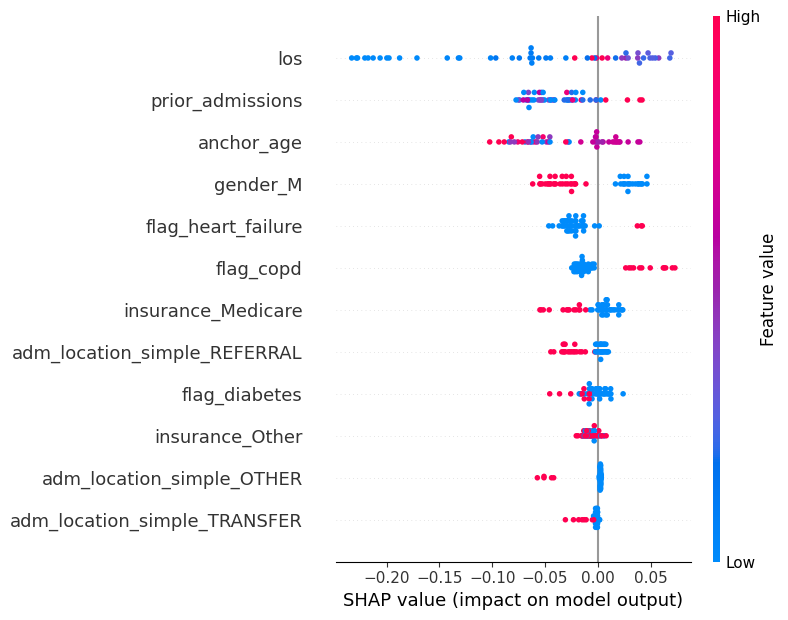

In [34]:
import shap
import numpy as np

# 1. Crear el explainer
explainer = shap.TreeExplainer(rf_model)

# 2. Tomar la muestra de datos
samples_to_take = min(100, len(X_test))
sample_test = X_test.sample(samples_to_take, random_state=42)

print(f"Calculando SHAP sobre {len(sample_test)} pacientes...")
shap_values = explainer.shap_values(sample_test)

# --- CORRECCIÓN DEL ERROR DE DIMENSIONES ---

# Verificamos si shap_values es una lista (versión vieja) o un array (versión nueva)
if isinstance(shap_values, list):
    # Versión antigua: Es una lista [matriz_clase0, matriz_clase1]
    # Queremos la clase 1 (Reingreso)
    vals_to_plot = shap_values[1]
elif len(shap_values.shape) == 3:
    # Versión nueva: Es un array 3D (muestras, features, clases)
    # Queremos todas las muestras (:), todas las features (:), y la clase 1 (índice 1)
    vals_to_plot = shap_values[:, :, 1]
else:
    # Caso fallback (por si acaso es regresión o algo raro)
    vals_to_plot = shap_values

# -------------------------------------------

# 3. Visualizar usando la matriz corregida
print("Generando gráfico de importancia...")
shap.summary_plot(vals_to_plot, sample_test)

## Interpretación Clínica de el Top 3
los (Length of Stay - Días de Estancia):

El modelo identificó que la duración del ingreso es el factor #1. Probablemente detectó que estancias muy cortas (altas precipitadas) o muy largas (pacientes complejos/debilitados) disparan el riesgo.

Acción: Esto valida que no podemos dar de alta "por reloj", sino por condición.

prior_admissions (Ingresos Previos):

El mejor predictor del futuro es el pasado. El modelo confirma que los pacientes con historial de reingresos son 'frecuentes' y necesitan un plan de cuidado diferente, no solo médico, sino social.

Acción: Programa de seguimiento intensivo para cualquiera con >2 ingresos en el último año.

anchor_age (Edad):

La fragilidad biológica juega un rol clave. A mayor edad, menor reserva fisiológica para recuperarse en casa sin ayuda.

Acción: Evaluar soporte familiar obligatorio para mayores de 75 años.